# **Proyek Machine Learning**

Nama: Melanie Sayyidina Sabrina Refman

## **Import Dataset**

In [1]:
from google.colab import files

# Mengupload file kaggle
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"melanierefman","key":"ce0211165e67e656e93a08a36a7acd09"}'}

In [3]:
# Mengonfigurasi Kaggle API di lingkungan Colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
# Mengunduh dataset dari Kaggle menggunakan Kaggle API
!kaggle datasets download -d rahmasleam/flowers-dataset/

Dataset URL: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset/versions/
License(s): apache-2.0
 95% 209M/219M [00:02<00:00, 98.0MB/s]
100% 219M/219M [00:02<00:00, 77.0MB/s]


In [5]:
from zipfile import ZipFile

# Mengekstrak file zip
file_name = "flowers-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction Completed')

Extraction Completed


## **Import Library**

In [55]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Import dari TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,
    Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

# Import dari scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## **Eksplorasi Awal Dataset**

In [7]:
# Path dataset
dataset_dir = "/content/flower_photos"
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Analisis distribusi data
data_info = []
for flower in classes:
    folder_path = os.path.join(dataset_dir, flower)
    file_list = os.listdir(folder_path)
    data_info.extend([(flower, file) for file in file_list])

# Konversi data menjadi DataFrame
df = pd.DataFrame(data_info, columns=['class', 'filename'])

In [8]:
# Tampilkan beberapa baris awal
print("Preview dataset:")
print(df.head())

Preview dataset:
   class                     filename
0  daisy   14698531521_0c2f0c6539.jpg
1  daisy    3758221664_b19116d61f.jpg
2  daisy  4697206799_19dd2a3193_m.jpg
3  daisy  2454280137_e1637536ae_n.jpg
4  daisy    3711723108_65247a3170.jpg


In [9]:
# Informasi dataset
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     3670 non-null   object
 1   filename  3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None


In [10]:
# Deskripsi statistik dataset
print("\nDeskripsi statistik dataset:")
print(df.describe())


Deskripsi statistik dataset:
            class                    filename
count        3670                        3670
unique          5                        3669
top     dandelion  15922772266_1167a06620.jpg
freq          898                           2


#### **Memeriksa Data yang Hilang**

In [11]:
# Cek missing values
missing_values = df.isnull().sum()
print("\nNilai hilang di setiap kolom:")
print(missing_values)


Nilai hilang di setiap kolom:
class       0
filename    0
dtype: int64


#### **Visualisasi Distribusi Label**

In [12]:
# Cek distribusi dataset
print("Distribusi dataset per kelas:")
print(df['class'].value_counts())

Distribusi dataset per kelas:
class
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64


<ipython-input-13-c6cc6709b1b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_count.index, y=data_count.values, palette='Set3')


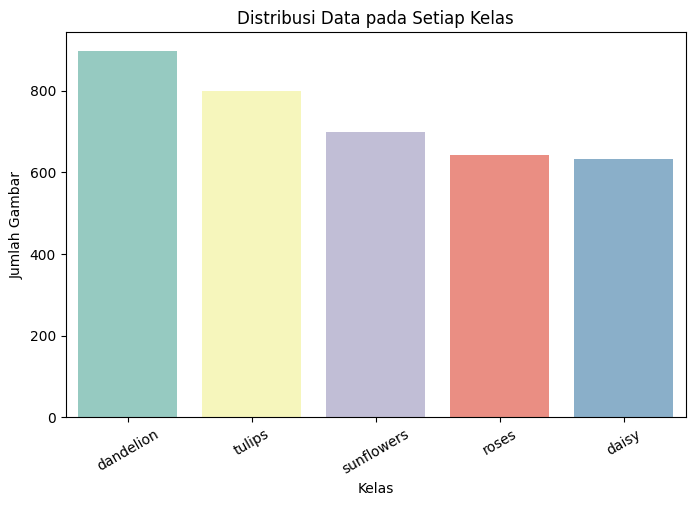

In [13]:
# Visualisasi distribusi label
data_count = df['class'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=data_count.index, y=data_count.values, palette='Set3')
plt.title('Distribusi Data pada Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=30)
plt.show()

#### **Visualisasi Contoh Gambar dari Setiap Kelas**

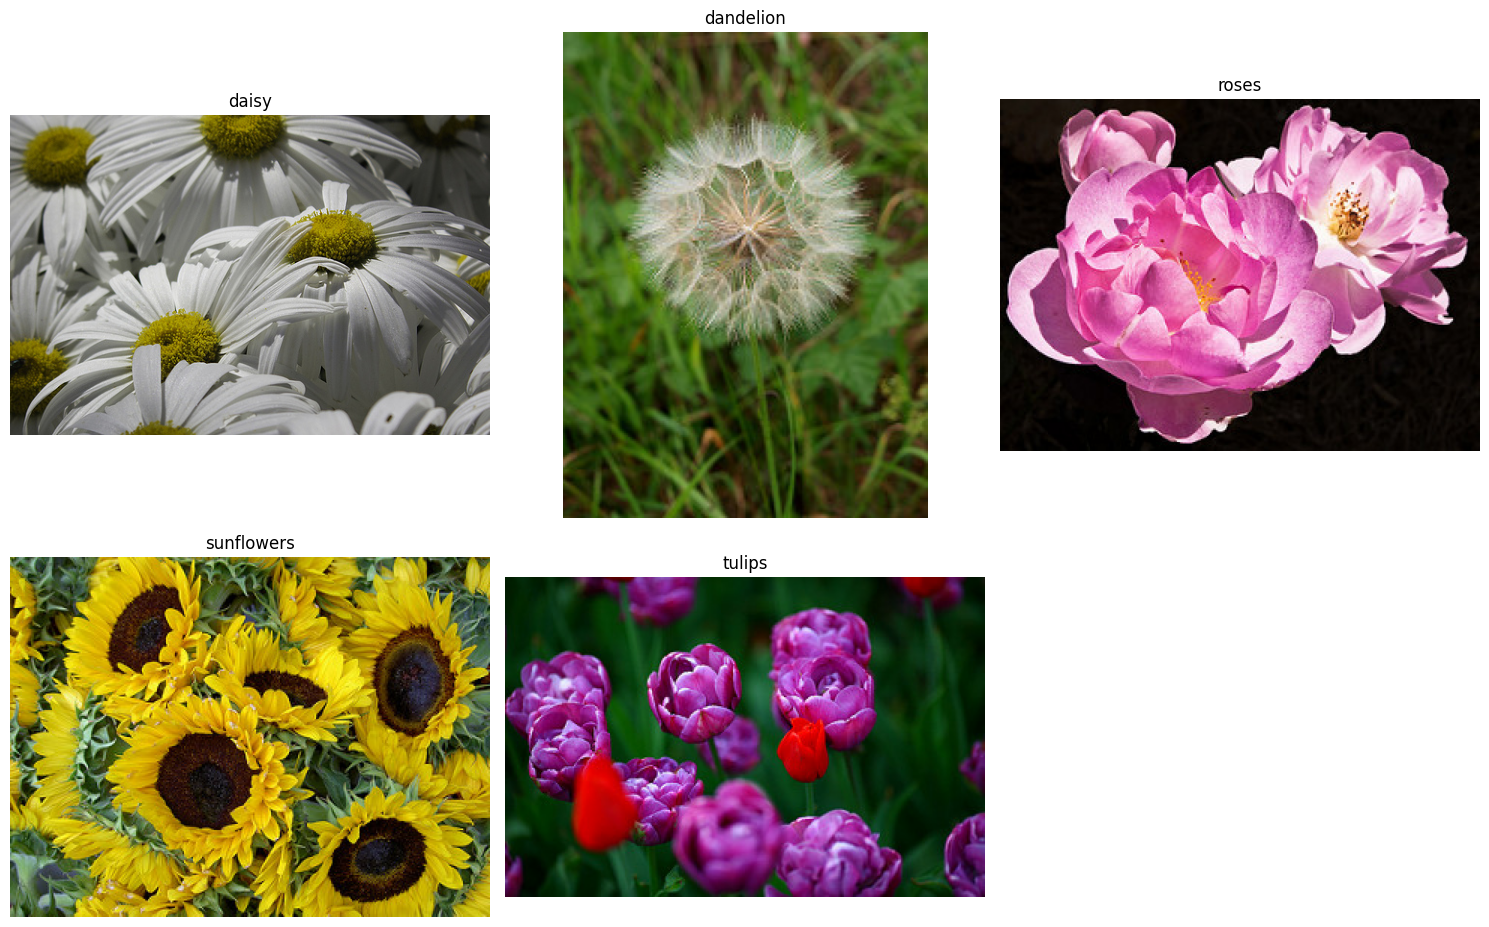

In [14]:
# Visualisasi contoh gambar dari setiap kelas
plt.figure(figsize=(15, 10))
for i, flower in enumerate(classes):
    folder_path = os.path.join(dataset_dir, flower)
    sample_image = os.path.join(folder_path, os.listdir(folder_path)[0])
    image = cv2.imread(sample_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(flower)
    plt.axis('off')
plt.tight_layout()
plt.show()

## **Data Preparation**



In [15]:
import os
import shutil
import random

output_dir = "/content/flower_dataset_split"

# Buat folder untuk train dan test
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Buat subfolder untuk setiap kelas di train dan test
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Proporsi data untuk train dan test
train_ratio = 0.8


# Bagi dataset
for class_name in classes:
    class_folder = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_folder)
    random.shuffle(images)

    train_count = int(len(images) * train_ratio)

    train_images = images[:train_count]
    test_images = images[train_count:]

    # Pindahkan gambar ke folder train
    for img in train_images:
        src_path = os.path.join(class_folder, img)
        dst_path = os.path.join(train_dir, class_name, img)
        shutil.copy(src_path, dst_path)

    # Pindahkan gambar ke folder test
    for img in test_images:
        src_path = os.path.join(class_folder, img)
        dst_path = os.path.join(test_dir, class_name, img)
        shutil.copy(src_path, dst_path)

print("Dataset telah dibagi menjadi train dan test!")

Dataset telah dibagi menjadi train dan test!


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalisasi pixel (0-1)
    rotation_range=30,    # Rotasi acak
    width_shift_range=0.2,# Pergeseran horizontal
    height_shift_range=0.2,# Pergeseran vertikal
    shear_range=0.2,      # Distorsi geser
    zoom_range=0.2,       # Zoom acak
    horizontal_flip=True, # Flip horizontal
    fill_mode='nearest'   # Isi piksel kosong
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Load Dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.


## **Modeling**

In [18]:
# Load pre-trained VGG16 model without the fully connected layers
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    # Fine-tune the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [21]:
# Create the model
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 2, 2, 64)            │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,027,845 (57.33 MB)

 Trainable params: 7,392,453 (28.20 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [23]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.8034 - loss: 0.5739 - val_accuracy: 0.8111 - val_loss: 0.5084 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.8313 - loss: 0.5013 - val_accuracy: 0.8438 - val_loss: 0.4457 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.8525 - loss: 0.4293 - val_accuracy: 0.8777 - val_loss: 0.3779 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.8788 - loss: 0.3709 - val_accuracy: 0.8927 - val_loss: 0.3171 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.8860 - loss: 0.3335 - val_accuracy: 0.8927 - val_loss: 0.3157 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9164 - loss: 0.2756 - val_accuracy: 0.8492 - val_loss: 0.5618 - learning_rate: 1.0000e-04
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 283ms/step - acc

## **Evaluation**

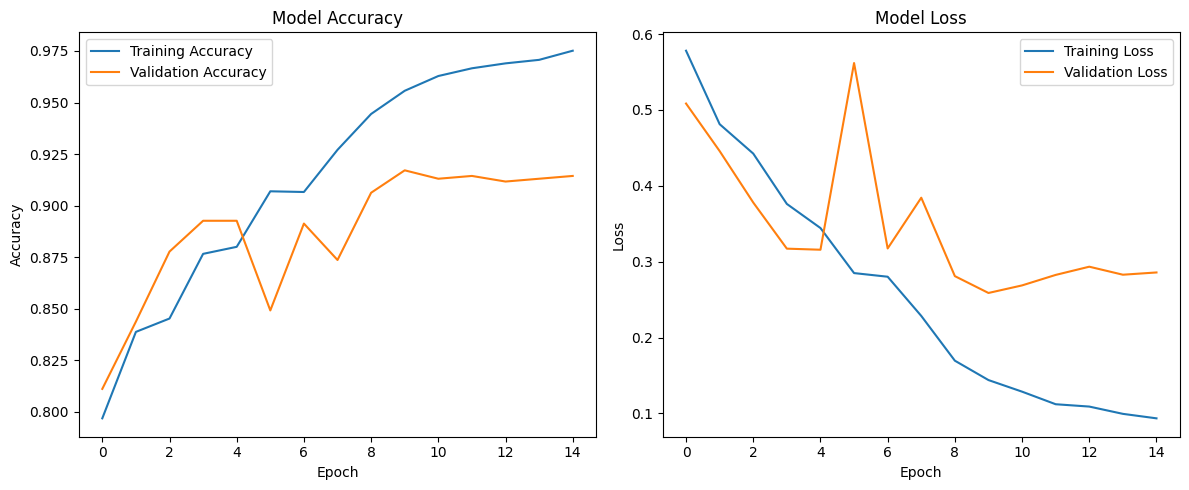

In [25]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Save Model**

In [26]:
# SavedModel
save_path = 'model'
tf.saved_model.save(model, save_path)

In [31]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_dir = 'tf_lite_model'
if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_path = os.path.join(tflite_model_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpulh3i_0v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_38')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132609263761392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263762096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263751712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263767920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263760336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263771264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263774080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263770208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263778304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132609263775136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13260926377

In [49]:
model.save('model_name.h5')

In [53]:
# TFJS
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model_name.h5 tfjs_model

2024-12-16 14:56:47.176709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734361007.211392   14026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734361007.222826   14026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [54]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.9.0.36.21
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.27.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1